In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime

### Data Loading and Processing

In [2]:
# read covid data
data = pd.read_csv("./covid_data/time_series_covid19_confirmed_US.csv", delimiter=',', index_col=0)
temp = data.groupby(['Province_State']).sum()
all_states_data = (temp.iloc[:, 5:]).T  # accumulative cases group by state
daily_states_data = all_states_data.diff()  # daily cases group by state
us_temp = data.groupby(['Country_Region']).sum()
us_data = (us_temp.iloc[:, 5:]).T  # accumulative cases of US
daily_us_data = us_data.diff()  # daily cases of US

In [8]:
# .npy file path of metric data
# senti_path = "../models/DifferentKeyWord/bays_sentiment.npy"
senti_path = "./covid_data/DifferentSentimentScoreAggregation_headline/pos-neg_time_series.npy"
docfreq_path = "./covid_data/DifferentKeyWord/frequency_count.npy"

In [5]:
# select dates
metric_day_1 = datetime.strptime("10/10/19", "%m/%d/%y")
covid_day_1 = datetime.strptime("1/22/20", "%m/%d/%y")
covid_day_end = datetime.strptime("10/9/20", "%m/%d/%y")

In [10]:
def load_metric(path, covid_day_1, covid_day_end, metric_day_1, metric_name):
    metric_score = np.load(path)
    ft_score = metric_score[:, 0]
    cnn_score = metric_score[:, 1]
    nyt_score = metric_score[:, 2]
    guardian_score = metric_score[:, 3]

    def convert2df(score, covid_day_1, covid_day_end, senti_day_1, metric_name):
        diff = (covid_day_1 - senti_day_1).days
        duration = (covid_day_end - covid_day_1).days
        temp = score[diff:]
        temp = temp[:duration + 1] 

        index = pd.date_range(covid_day_1, covid_day_end, freq='D').strftime(
            '%m/%d/%y')
        columns = [metric_name]
        score_df = pd.DataFrame(temp, index=index, columns=columns)
        return score_df
    
    ft_score_df = convert2df(ft_score, covid_day_1, covid_day_end, metric_day_1,
                             metric_name)
    cnn_score_df = convert2df(cnn_score, covid_day_1, covid_day_end,
                              metric_day_1, metric_name)
    nyt_score_df = convert2df(nyt_score, covid_day_1, covid_day_end,
                              metric_day_1, metric_name)
    guardian_score_df = convert2df(guardian_score, covid_day_1, covid_day_end,
                                   metric_day_1, metric_name)
    media_dict = {"nyt": nyt_score_df, "cnn": cnn_score_df, "ft": ft_score_df,
                  "guardian": guardian_score_df}
    return media_dict

In [11]:
# load metric data
senti_media_dict = load_metric(senti_path, covid_day_1, covid_day_end,
                               metric_day_1, metric_name="senti_score")
docfreq_media_dict = load_metric(docfreq_path, covid_day_1, covid_day_end,
                                 metric_day_1, metric_name="doc frequency")

### Metric 1: Key Term's Document Frequency

In [13]:
# overlap key terms' document frequency with state covid data
def overlap_docfreq(daily_states_data, state, docfreq, media_name):
    daily_onestate_data = daily_states_data[[state]]
    roll7_state_data = daily_onestate_data.rolling(7).mean()
    roll7_docfreq = docfreq.rolling(7).mean()

    # normalize the scale of docfreq data
    roll7_covid_np = roll7_state_data.to_numpy()[7:]    # convert to np
    roll7_metric_np = roll7_docfreq.to_numpy()[8:]
    covid_max_idx = np.argmax(roll7_covid_np)       # find idx with max val.
    metric_max_idx = np.argmax(roll7_metric_np)
    covid_max = roll7_covid_np[covid_max_idx][0]    # find max val.
    metric_max = roll7_metric_np[metric_max_idx][0]
    norm_roll7_docfreq = roll7_docfreq * (covid_max/metric_max)

    fig, ax = plt.subplots(figsize=(20, 10))
    daily_onestate_data.plot(kind='bar', ax=ax)
    roll7_state_data.plot(color='red', ax=ax)
    norm_roll7_docfreq.plot(color='green', ax=ax)
    ax.legend(['7-day running average of cases',
               'Normalized 7-day running avg of %s doc frequency' % media_name,
               'actual daily cases'])
    plt.grid()
    ax.xaxis_date()
    my_xLocator = mticker.MultipleLocator(7)
    ax.xaxis.set_major_locator(my_xLocator)
    my_yLocator = mticker.MultipleLocator(1000)
    ax.yaxis.set_major_locator(my_yLocator)
    fig.autofmt_xdate()
    plt.title("Daily Cases and 7-Day Running Average for %s State" % state)
    plt.xlabel('Dates')
    plt.ylabel('Daily new cases & Normalized document frequency')
    plt.show()

In [26]:
# overlap key terms' document frequency with state covid data
def overlap_docfreq_us(daily_us_data, docfreq, media_name):
    roll7_us_data = daily_us_data.rolling(7).mean()
    roll7_docfreq = docfreq.rolling(7).mean()

    # normalize the scale of docfreq data
    roll7_covid_np = roll7_us_data.to_numpy()[7:]    # convert to np
    roll7_metric_np = roll7_docfreq.to_numpy()[8:]
    covid_max_idx = np.argmax(roll7_covid_np)       # find idx with max val.
    metric_max_idx = np.argmax(roll7_metric_np)
    covid_max = roll7_covid_np[covid_max_idx][0]    # find max val.
    metric_max = roll7_metric_np[metric_max_idx][0]
    norm_roll7_docfreq = roll7_docfreq * (covid_max/metric_max)

    fig, ax = plt.subplots(figsize=(20, 10))
    daily_us_data.plot(kind='bar', ax=ax)
    roll7_us_data.plot(color='red', ax=ax)
    norm_roll7_docfreq.plot(color='green', ax=ax)
    ax.legend(['7-day running average of cases',
               'Normalized 7-day running avg of %s doc frequency' % media_name,
               'actual daily cases'])
    plt.grid()
    ax.xaxis_date()
    my_xLocator = mticker.MultipleLocator(7)
    ax.xaxis.set_major_locator(my_xLocator)
    my_yLocator = mticker.MultipleLocator(5000)
    ax.yaxis.set_major_locator(my_yLocator)
    fig.autofmt_xdate()
    plt.title("Daily Cases and 7-Day Running Average for US")
    plt.xlabel('Dates')
    plt.ylabel('Daily new cases & Normalized document frequency')
    plt.show()

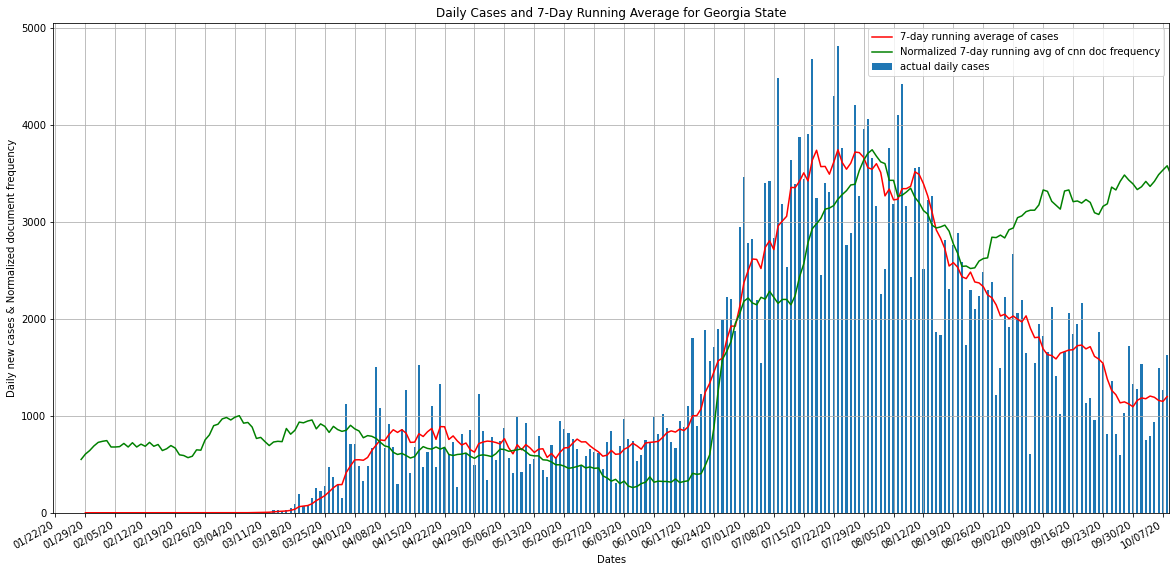

In [17]:
# select state of interest
state_of_interest = 'Georgia'

# select plotting option
m1_option = 2 # choose from {1, 2}

# Option 1 (state): plot sentiment scores from all media
if m1_option == 1:
    for key in docfreq_media_dict.keys():
        overlap_docfreq(daily_states_data, state_of_interest,
                        docfreq_media_dict[key], key)
# Option 2 (state): select media of interest and produce 1 plot only
elif m1_option == 2:
    media = "cnn"
    overlap_docfreq(daily_states_data, state_of_interest,
                    docfreq_media_dict[media], media)

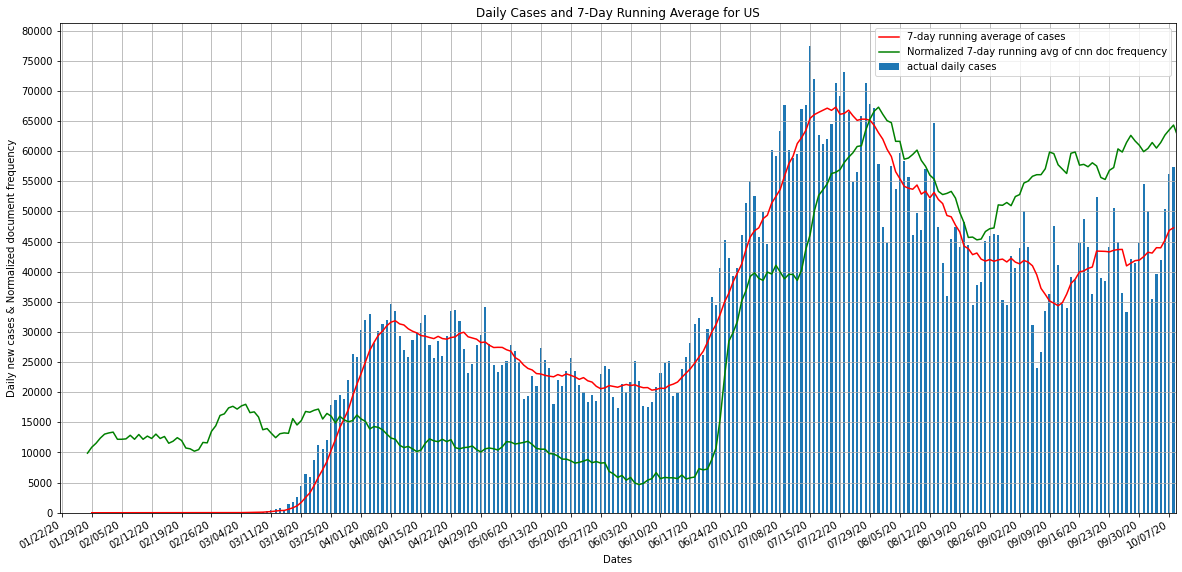

In [27]:
# select plotting option
m1_option = 4 # choose from {3, 4}

# Option 3 (US): plot sentiment scores from all media
if m1_option == 3:
    for key in docfreq_media_dict.keys():
        overlap_docfreq_us(daily_us_data, docfreq_media_dict[key], key)
# Option 4 (US): select media of interest and produce 1 plot only
elif m1_option == 4:
    media = "cnn"
    overlap_docfreq_us(daily_us_data, docfreq_media_dict[media], media)

### Metric 2: Sentiment Score

In [19]:
# overlap sentiment score and state covid data
def overlap_sentiscore(daily_states_data, state, senti_score, media_name):
    daily_onestate_data = daily_states_data[[state]]
    roll7_state_data = daily_onestate_data.rolling(7).mean()
    roll7_senti_score = senti_score.rolling(7).mean()

    # normalize the scale of docfreq data
    roll7_covid_np = roll7_state_data.to_numpy()[7:]    # convert to np
    roll7_metric_np = np.absolute(roll7_senti_score.to_numpy()[8:])
    covid_max_idx = np.argmax(roll7_covid_np)       # find idx with max val.
    metric_max_idx = np.argmax(roll7_metric_np)
    covid_max = roll7_covid_np[covid_max_idx][0]    # find max val.
    metric_max = roll7_metric_np[metric_max_idx][0]
    norm_roll7_senti_score = roll7_senti_score * (covid_max/metric_max)

    fig, ax = plt.subplots(figsize=(20, 10))
    daily_onestate_data.plot(kind='bar', ax=ax)
    roll7_state_data.plot(color='red', ax=ax)
    norm_roll7_senti_score.plot(color='green', ax=ax)
    # ax.legend(['7-day running average of cases', 'actual daily cases'])
    ax.legend(['7-day running average of cases',
               'Normalized 7-day running avg of %s Sentiment Scores' % media_name,
               'actual daily cases'])
    plt.grid()
    my_xLocator = mticker.MultipleLocator(7)
    ax.xaxis.set_major_locator(my_xLocator)
    my_yLocator = mticker.MultipleLocator(1000)
    ax.yaxis.set_major_locator(my_yLocator)
    fig.autofmt_xdate()
    plt.title("Daily Cases and 7-Day Running Average for %s State" % state)
    plt.xlabel('Dates')
    plt.ylabel('Daily new cases & Normalized sentiment score')
    plt.show()

In [24]:
# overlap sentiment score and state covid data
def overlap_sentiscore_us(daily_us_data, senti_score, media_name):
    roll7_us_data = daily_us_data.rolling(7).mean()
    roll7_senti_score = senti_score.rolling(7).mean()

    # normalize the scale of docfreq data
    roll7_covid_np = roll7_us_data.to_numpy()[7:]    # convert to np
    roll7_metric_np = np.absolute(roll7_senti_score.to_numpy()[8:])
    covid_max_idx = np.argmax(roll7_covid_np)       # find idx with max val.
    metric_max_idx = np.argmax(roll7_metric_np)
    covid_max = roll7_covid_np[covid_max_idx][0]    # find max val.
    metric_max = roll7_metric_np[metric_max_idx][0]
    norm_roll7_senti_score = roll7_senti_score * (covid_max/metric_max)

    fig, ax = plt.subplots(figsize=(20, 10))
    daily_us_data.plot(kind='bar', ax=ax)
    roll7_us_data.plot(color='red', ax=ax)
    norm_roll7_senti_score.plot(color='green', ax=ax)
    # ax.legend(['7-day running average of cases', 'actual daily cases'])
    ax.legend(['7-day running average of cases',
               'Normalized 7-day running avg of %s Sentiment Scores' % media_name,
               'actual daily cases'])
    plt.grid()
    ax.xaxis_date()
    my_xLocator = mticker.MultipleLocator(7)
    ax.xaxis.set_major_locator(my_xLocator)
    my_yLocator = mticker.MultipleLocator(5000)
    ax.yaxis.set_major_locator(my_yLocator)
    fig.autofmt_xdate()
    plt.title("Daily Cases and 7-Day Running Average for the US")
    plt.xlabel('Dates')
    plt.ylabel('Daily new cases & Normalized sentiment score')
    plt.show()

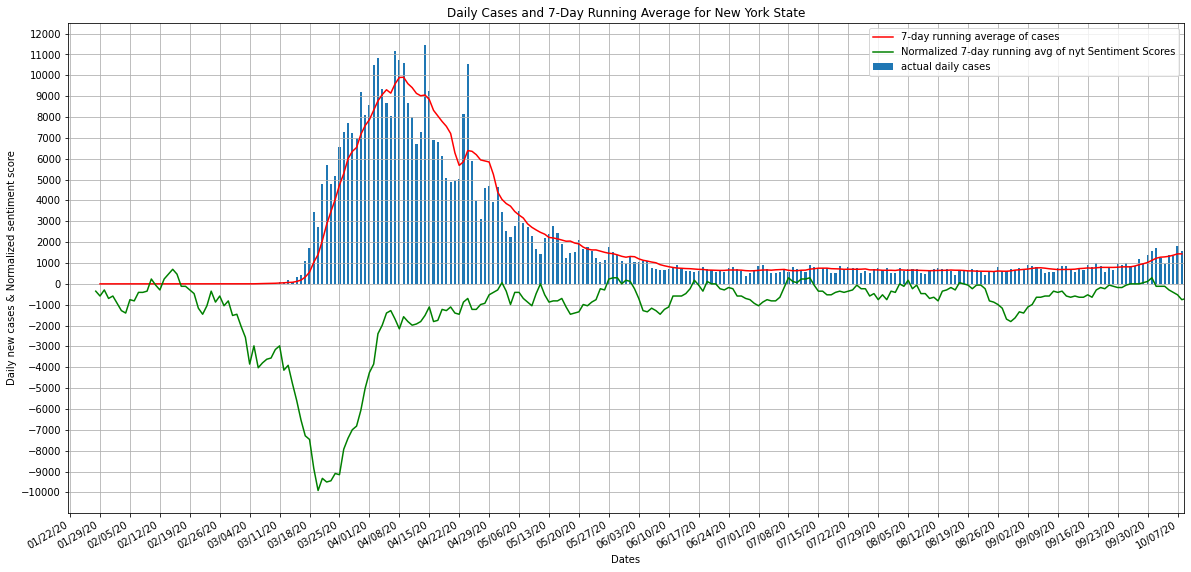

In [22]:
# select state of interest
state_of_interest = 'New York'

# select plotting option
m2_option = 2  # choose {1, 2}

# Option 1 (state): plot sentiment scores from all media
if m2_option == 1:
    for key in senti_media_dict.keys():
        overlap_sentiscore(daily_states_data, state_of_interest,
                           senti_media_dict[key], key)
# Option 2 (state): select media of interest and produce 1 plot only
elif m2_option == 2:
    media = "nyt"
    overlap_sentiscore(daily_states_data, state_of_interest,
                       senti_media_dict[media], media)

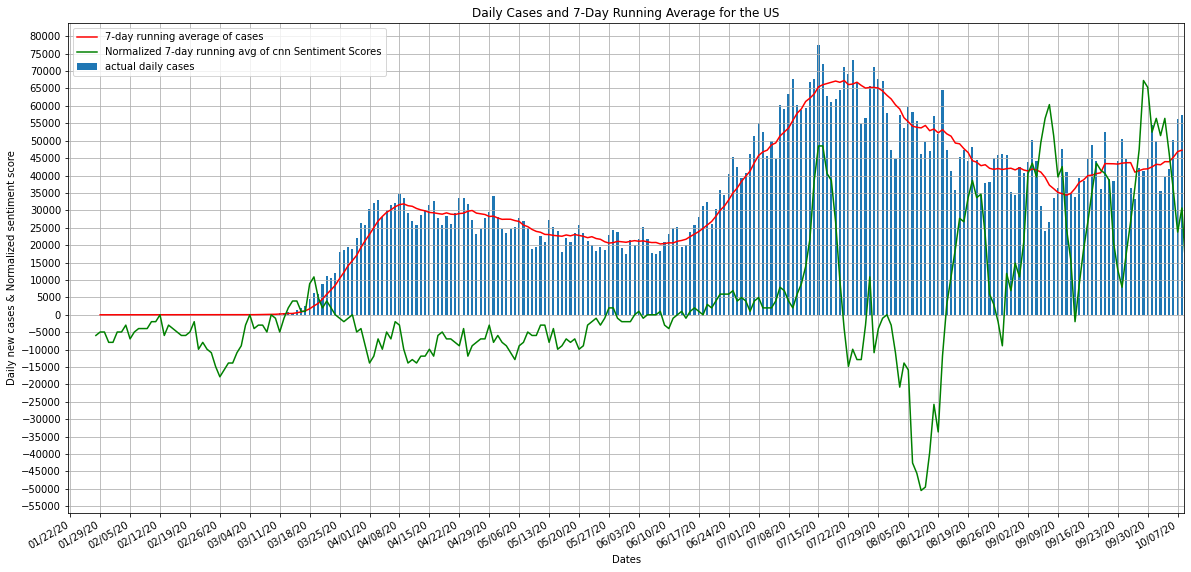

In [25]:
# select plotting option
m2_option = 4  # choose {3, 4}

# Option 3 (us): plot sentiment scores from all media
if m2_option == 3:
    for key in senti_media_dict.keys():
        overlap_sentiscore_us(daily_us_data, senti_media_dict[key], key)
# Option 4 (us): select media of interest and produce 1 plot only
elif m2_option == 4:
    media = "cnn"
    overlap_sentiscore_us(daily_us_data, senti_media_dict[media], media)